### This  file is specific to preprocessing and first-round data cleaning requirements. Take the new JSON files generated from here and use it separately for the purposes of exploration and modelling

In [1]:
import numpy as np
import scipy
import random
import urllib
import matplotlib.pyplot as plt
import json

In [2]:
random.seed(0) #set an initial seed so that we can reproduce consistently

In [3]:
def readJSONfromFile(fname):
    yelp_data = []
    with open(fname) as f:
        for line in f:
            yelp_data.append(json.loads(line))
    return yelp_data

In [29]:
Iu = readJSONfromFile('data/yelp_Iu.json')

In [31]:
Iu = Iu[0]

In [32]:
len(Iu)

721779

In [34]:
Iu['PmgqNO0-5Y3e3UoR61TD7w']

21

In [45]:
I = readJSONfromFile('data/yelp_restaurant_data.json')

In [49]:
I = I[0]

In [50]:
AllRest = []
for i in I:
    AllRest.append(i['business_id'])

In [82]:
np.random.rand(10)

array([ 0.38687244,  0.6089526 ,  0.78783475,  0.38597039,  0.59112124,
        0.79973716,  0.29162575,  0.50246842,  0.51318607,  0.33347705])

In [83]:
AllUser = Iu.keys()

In [85]:
len(AllUser)

721779

In [86]:
len(AllRest)

48485

In [87]:
AllRestSet = set(AllRest)

In [88]:
Lambda = 1
Alpha = 10**-5
K = 10

In [89]:
Gamma_u = {}
Gamma_r = {}

In [90]:
for user in AllUser:
    Gamma_u[user] = np.random.rand(K)
for rest in AllRest:
    Gamma_r[rest] = np.random.rand(K)

In [91]:
def logit(t):
    return np.exp(-t)/(1+np.exp(-t))

In [92]:
def sigmoid(t):
    return 1-logit(t)

In [93]:
import math
def vlen(t):
    su = 0
    for i in t:
        su += i*i
    return su

In [111]:
CUser = []
Cirest = []
Cjrest = []
iterations = 100000

In [112]:
def loss(CUser,Cirest,Cjrest):
    su = 0
    count = 0
    for user in CUser:
#         print(count)
        count +=1
        for irest in Cirest:
            for jrest in Cjrest:
                xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
                su += np.log(sigmoid(xuij))
    for user in CUser:
        su += Lambda* vlen(Gamma_u[user])
    for rest in Cirest:
        su += Lambda* vlen(Gamma_r[rest])
    for rest in Cjrest:
        su += Lambda* vlen(Gamma_r[rest])
    return su

In [113]:
for i in range(iterations):
    if i%10 == 0:
        print i/10
    user = random.choice(Iu.keys())
    CUser.append(user)
    irest = random.choice(Iu[user])
    Cirest.append(irest)
    jrest = random.choice(list(AllRestSet - set(Iu[user])))
    Cjrest.append(jrest)
    xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
    Gamma_u[user] += Alpha*(logit(xuij)*(Gamma_r[irest]-Gamma_r[jrest]) + Lambda*Gamma_u[user])
    Gamma_r[irest]+= Alpha*(logit(xuij)*(Gamma_u[user]) + Lambda*Gamma_r[irest])
    Gamma_r[jrest]+= Alpha*(logit(xuij)*(-Gamma_u[user]) + Lambda*Gamma_r[jrest])
    if i%100 == 0:
        print loss(CUser,Cirest,Cjrest)
    

0
7.42623837588
1
2
3
4
5
6
7
8
9
10
-824506.003971
11
12
13
14
15
16
17
18
19
20
-6601376.07134
21
22
23
24
25
26
27
28
29
30


KeyboardInterrupt: 

In [5]:
print("The dataset has {} businesses".format(len(data)))

The dataset has 144072 businesses


In [6]:
data[11]

{u'address': u'1500 N Green Valley Pkwy, Ste 230',
 u'attributes': [u'Alcohol: none',
  u"Ambience: {'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
  u'BusinessAcceptsCreditCards: True',
  u"BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  u'Caters: True',
  u'GoodForKids: True',
  u"GoodForMeal: {'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'breakfast': False, 'brunch': False}",
  u'HasTV: True',
  u'NoiseLevel: quiet',
  u'OutdoorSeating: False',
  u'RestaurantsAttire: casual',
  u'RestaurantsDelivery: False',
  u'RestaurantsGoodForGroups: True',
  u'RestaurantsPriceRange2: 1',
  u'RestaurantsReservations: False',
  u'RestaurantsTableService: False',
  u'RestaurantsTakeOut: True',
  u'WiFi: no'],
 u'business_id': u'42romV8altAeuZuP2OC1gw',
 u'categories': [u'Hawaiian', u'Restaurants', u'Barbeq

### Restaurant Data preprocessing

#### We only want restaurant data. Yelp data is clean, in the sense that every business which is a restaurant, has a restaurant category at the least. Bakeries or sometime coffee places are not tagged restaurant, which is acceptable

In [7]:
restaurant_data = []
restaurant_id_set = set()   #set of ids of business = restaurant useful for processing of other json files
for business in data:
    if business["categories"]!= None and "Restaurants" in business["categories"]:
        restaurant_data.append(business)
        restaurant_id_set.add(business["business_id"])
        

In [8]:
print("The number of businesses which are just restaurants is {}".format(len(restaurant_data)))

The number of businesses which are just restaurants is 48485


In [9]:
with open('yelp_restaurant_data.json', 'w') as outfile:
    json.dump(restaurant_data, outfile)


### User review data processing
#### Choose only those reviews pertaining to restaurants and store the reduced set of reviews

In [10]:
yelp_user_review_data = []
with open("data/yelp_academic_dataset_review.json", "U") as f:
    for line in f:
        review = json.loads(line)
        if review["business_id"] in restaurant_id_set:
            yelp_user_review_data.append(review)

In [11]:
print("Number of user reviews pertaining to restaurants is {}".format(len(yelp_user_review_data)))

Number of user reviews pertaining to restaurants is 2577298


In [12]:
with open('yelp_user_review_data.json', 'w') as outfile:
    json.dump(yelp_user_review_data, outfile)

In [13]:
f.close()
outfile.close()

In [15]:
yelp_user_review_data[0]

{u'business_id': u'4P-vTvE6cncJyUyLh73pxw',
 u'cool': 0,
 u'date': u'2014-03-29',
 u'funny': 0,
 u'review_id': u'6-hKBi-6RC3g7Mft0c-6qw',
 u'stars': 4,
 u'text': u'This place is a area staple! Been around for years and not much has changed - I see this as a good thing! Stable and reliable!\n\nMy family goes every year for St. Pattys Day corn beef! Very nice place for a bar night dinner, or to catch up with some friends over drinks!',
 u'type': u'review',
 u'useful': 0,
 u'user_id': u'PmgqNO0-5Y3e3UoR61TD7w'}

In [19]:
I_u = {}
U_i = {}

In [52]:
cutoff= 400000

In [57]:
for datum in yelp_user_review_data:
    if I_u.has_key(datum['business_id']):
        I_u[datum['business_id']].append(datum['stars'])
    else:
        I_u[datum['business_id']] = [datum['stars']]
    if U_i.has_key(datum['user_id']):
        U_i[datum['user_id']].append(datum['stars'])
    else:
        U_i[datum['user_id']] = [datum['stars']]
    

In [58]:
len(I_u['4P-vTvE6cncJyUyLh73pxw'])

92

In [96]:
thresh = 10

In [97]:
len_u = []
len_i = []
for k in I_u.keys():
    if len(I_u[k]) > thresh:
        len_i.append(len(I_u[k]))
for k in U_i.keys():
    if len(U_i[k]) > thresh:
        len_u.append(len(U_i[k]))
    

In [105]:
import numpy
avg_u = []
avg_i = []
for k in I_u.keys():
    if len(I_u[k]) > thresh:
        avg_i.append(numpy.mean(I_u[k]))
for k in U_i.keys():
    if len(U_i[k]) > thresh:
        avg_u.append(numpy.mean(U_i[k]))
    

In [92]:
len_u = []
len_i = []
for k in I_u.keys():
    len_i.append(len(I_u[k]))
for k in U_i.keys():
    len_u.append(len(U_i[k]))
    

In [98]:
len_u.sort()
len_u = len_u[:int(len(len_u)*0.99)]

In [103]:
len_i.sort()
len_i = len_i[:int(len(len_i)*0.99)]

I_u[I_u.keys()[0]]

len(len_i)

count = 0
for i in len_i:
    if i > 10:
        count +=1
print(count)

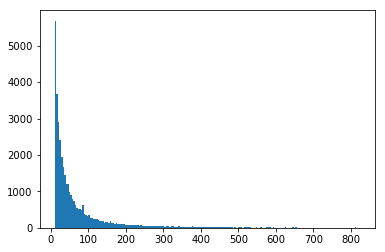

In [104]:
import matplotlib.pyplot as plt

plt.hist(len_i,bins=200)
plt.show()

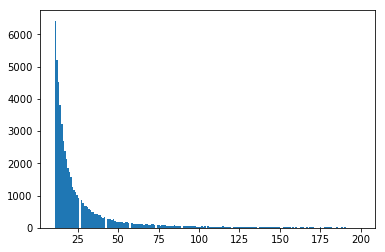

In [102]:
plt.hist(len_u,bins=200)
plt.show()

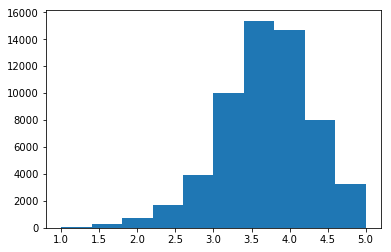

In [106]:
plt.hist(avg_u)
plt.show()

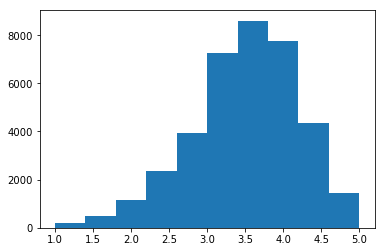

In [107]:
plt.hist(avg_i)
plt.show()

In [124]:
latitudes = [[],[],[],[]]
longitudes = [[],[],[],[]]
for datum in restaurant_data:
    if datum['stars'] == 5:
        latitudes[-1].append(datum['latitude'])
        longitudes[-1].append(datum['longitude']) 
    else:
        latitudes[int(datum['stars'])-1].append(datum['latitude'])
        longitudes[int(datum['stars'])-1].append(datum['longitude'])

In [114]:
latitudes[0]

43.661054

In [126]:
import gmplot

gmap = gmplot.GoogleMapPlotter(37.428, -122.145, 16)

# gmap.plot(latitudes, longitudes, 'cornflowerblue', edge_width=10)
# gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
# gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
# gmap.heatmap(latitudes, longitudes)

gmap.scatter(latitudes[0], longitudes[0],'#c41d00', size=40, marker=False)
gmap.scatter(latitudes[1], longitudes[1],'#fc9a10', size=40, marker=False)
gmap.scatter(latitudes[2], longitudes[2],'#fcf811', size=40, marker=False)
gmap.scatter(latitudes[3], longitudes[3],'#008712', size=40, marker=False)
# gmap.scatter(latitudes[4], longitudes[4],'#11ff31', size=40, marker=False)

gmap.draw("mymap.html")

### User data processing
#### the user.json file has many attributes for each JSON object which are not relevant to our task. These are removed and a new json file is created

#### The attributes retained has the review_count and the average_stars which is across all Yelp business. We can get the right count from the restaurant review data specifically.
#### We only want the users who have written atleast one review (i.e. gone to one restaurant at the least). This removes the cold-start problem for now

In [14]:
yelp_user_data = []
keep_property_arr= ["user_id","name","yelping_since","review_count", "average_stars","fans"]  #these are the attributes to keep

with open("data/yelp_academic_dataset_user.json", "U") as f:
    for line in f:
        user = json.loads(line)
        user_jsobobj = dict()
        for property in keep_property_arr:
            user_jsobobj[property] = user[property]
        yelp_user_data.append(user_jsobobj)
        

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\saicharan\Anaconda3\envs\py27\lib\site-packages\IPython\core\ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\saicharan\Anaconda3\envs\py27\lib\site-packages\IPython\core\ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "C:\Users\saicharan\Anaconda3\envs\py27\lib\site-packages\IPython\core\ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "C:\Users\saicharan\Anaconda3\envs\py27\lib\inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "C:\Users\saicharan\Anaconda3\envs\py27\lib\inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "C:\Users\saicharan\Anaconda3\envs\py27\lib\inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(obje

IndexError: string index out of range

In [ ]:
yelp_user_data[100]

In [ ]:
len(yelp_user_data)

In [ ]:
with open('yelp_user_data.json', 'w') as outfile:
    json.dump(yelp_user_data, outfile)
    print("File {} written".format("yelp_user_data.json"))
    outfile.close()
    f.close()